In [1]:
import torch
import PIL
import PIL.Image
import numpy as np
import matplotlib.pylab as plt
from torchvision.transforms.transforms import ToTensor, Compose, Resize
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

import sys
sys.path.append('../')
from tools.inject_backdoor import patch_trigger
from tools.img import rgb2yuv, dct_2d_3c_full_scale, tensor2ndarray, ndarray2tensor
from tools.prepare_data import get_dataset
from tools.utils import manual_seed

manual_seed(33)

In [2]:
dataset_name = 'cifar10'
scale = 32

class MyConfig:
    pass

config = MyConfig()

# BadNets
badnets_config = MyConfig()
badnets_config.__dict__ = {
    'name': 'badnet',
    'mode': 'train',
    'tg_path': '/home/chengyiqiu/code/SanDiffusion/resource/badnet/',
}

# Blend
blend_config = MyConfig()
blend_config.__dict__ = {
    'name': 'blended',
    'mode': 'train',
    'tg_path': '/home/chengyiqiu/code/SanDiffusion/resource/blended/hello_kitty.jpeg',
    'blended_coeff': 0.2,
}

# FTrojan
ftrojan_config = MyConfig()
ftrojan_config.__dict__ = {
    'name': 'ftrojan',
    'mode': 'train',
    'channel_list': [1,2],
    'magnitude': 50,
    'YUV': True,
    'window_size': 32,
    'pos_list': [15,15,31,31],
}

# Refool
refool_config = MyConfig()
refool_config.__dict__ = {
    'name': 'refool',
    'mode': 'train',
    'r_adv_img_folder_path': '/home/chengyiqiu/code/Phojan/resource/refool/Refool-SelectedReflectionImages/selected_out-images',
    'ghost_rate': 0.49,
    'alpha_t': 0.4,
    'offset': [0, 0],
    'sigma': -1,
    'ghost_alpha': -1,
}

transforms = Compose([
    ToTensor(), Resize((scale, scale))
])
ds_list = get_dataset(dataset_name, transforms, False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
n = 0
total = 1024

config.__dict__ = {
    'dataset_name': dataset_name,
    'attack': ftrojan_config
}

res_before = np.zeros((scale, scale, 3), dtype=np.float32)
res_after_1 = np.zeros((scale, scale, 3), dtype=np.float32)
res_after_2 = np.zeros((scale, scale, 3), dtype=np.float32)


def sigmoid_beta(t):
    # 参数设置
    n_steps = 1000
    beta_start = 1e-4
    beta_end = 2e-2

    # 生成 beta 序列
    beta_linear = torch.linspace(-6, 6, n_steps)
    beta = torch.sigmoid(beta_linear) * (beta_end - beta_start) + beta_start

    # 计算 alpha 序列
    alpha = 1 - beta

    # 累积计算 alpha_bar (数值稳定方法)
    alpha_bar = torch.cumprod(alpha, dim=0)

    # 提取 t=100 的值
    alpha_bar_100 = alpha_bar[t]
    noise_scale = torch.sqrt(1 - alpha_bar_100)
    return alpha_bar_100, noise_scale

x4v = None
x4v_p1 = None
x4v_p2 = None

t = 150

with tqdm(initial=n, total=total) as pbar:
    artifacts = torch.zeros(size=(3, scale, scale))
    artifacts_p = patch_trigger(artifacts, config)
    for x_0 in ds_list:
        x_space = x_0  # this is a tensor
        x_space_poison_1 = patch_trigger(x_space.clone(), config)  # tensor too
        x_space_poison_2 = x_space.clone() + artifacts_p

        x_space_poison_1.clip_(0, 1)
        x_space_poison_2.clip_(0, 1)
        
        alpha_bar_100, noise_scale = sigmoid_beta(t)
        x_space_poison_1 = x_space_poison_1 * alpha_bar_100 + torch.randn_like(x_space_poison_1).to(x_space_poison_1) * noise_scale

        x_space, x_space_poison_1, x_space_poison_2 = tensor2ndarray(x_space), tensor2ndarray(x_space_poison_1), tensor2ndarray(x_space_poison_2)
        x_f = dct_2d_3c_full_scale(x_space.astype(float))
        x_f_poison_1 = dct_2d_3c_full_scale(x_space_poison_1.astype(float))
        x_f_poison_2 = dct_2d_3c_full_scale(x_space_poison_2.astype(float))
        res_before += x_f
        res_after_1 += x_f_poison_1
        res_after_2 += x_f_poison_2
        n += 1

        if n == 2:
            x4v, x4v_p1, x4v_p2 = x_space, x_space_poison_1, x_space_poison_2

        pbar.update(1)
        if n >= total:
            print(n)
            print(alpha_bar_100, noise_scale)
            res_before /= n
            res_after_1 /= n
            res_after_2 /= n
            break


100%|██████████| 1024/1024 [00:01<00:00, 618.08it/s]

1024
tensor(0.9648) tensor(0.1877)


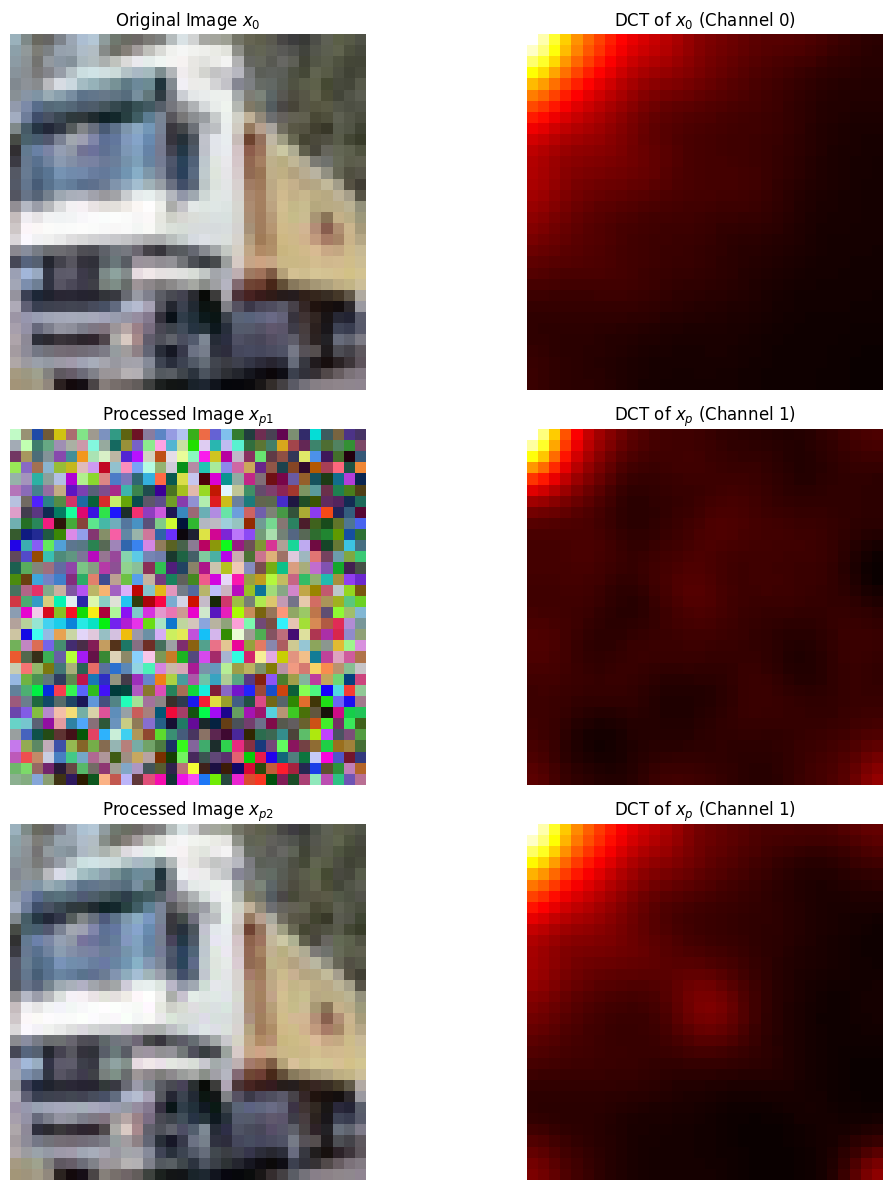

In [4]:
def clip(data: np.ndarray) -> np.ndarray:
    if data.shape[0] > 64:
        return np.clip(a=data, a_min=1.5, a_max=4.5)
    else:
        from scipy.ndimage import gaussian_filter
        data = np.log1p(np.abs(data))
        data = gaussian_filter(data, sigma=2)
        return data

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

dct_c = clip(res_before)
dct_p1 = clip(res_after_1)
dct_p2 = clip(res_after_2)

axes[0, 0].imshow(x4v)
axes[0, 0].set_title('Original Image $x_0$')
axes[0, 0].axis('off')

axes[0, 1].imshow(dct_c[:, :, 0], cmap='hot')
axes[0, 1].set_title('DCT of $x_0$ (Channel 0)')
axes[0, 1].axis('off')

axes[1, 0].imshow(x4v_p1)
axes[1, 0].set_title('Processed Image $x_{p1}$')
axes[1, 0].axis('off')

axes[1, 1].imshow(dct_p1[:, :, 0], cmap='hot')
axes[1, 1].set_title('DCT of $x_p$ (Channel 1)')
axes[1, 1].axis('off')

axes[2, 0].imshow(x4v_p2)
axes[2, 0].set_title('Processed Image $x_{p2}$')
axes[2, 0].axis('off')

axes[2, 1].imshow(dct_p2[:, :, 0], cmap='hot')
axes[2, 1].set_title('DCT of $x_p$ (Channel 1)')
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()
